## 1. 模型架构

### 1.1 编码器

In [18]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # LSTM模型
    
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        return hidden  # 只需要输出hidden

### 1.2 解码器

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers)  # LSTM模型
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        x, state = self.lstm(x, hidden)
        x = self.linear(x)
        return x, state

### 1.3. seq2seq模型

In [20]:
class Seq2Seq(nn.Module):
 
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

## 2. 序列到序列模型简单实现

### 2.1 数据集准备

In [21]:
import random

# 数据集生成
soundmark = ['ei',  'bi:',  'si:',  'di:',  'i:',  'ef',  'dʒi:',  'eit∫',  'ai', 'dʒei', 'kei', 'el', 'em', 'en', 'əu', 'pi:', 'kju:',
        'ɑ:', 'es', 'ti:', 'ju:', 'vi:', 'd∧blju:', 'eks', 'wai', 'zi:']

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
         'r','s','t','u','v','w','x','y','z']

t = 10000 #总条数
r = 0.9   #扰动项
seq_len = 6
src_tokens, tgt_tokens = [],[] #原始序列、目标序列列表

for i in range(t):
    src, tgt = [],[]
    for j in range(seq_len):
        ind = random.randint(0,25)
        src.append(soundmark[ind])
        if random.random() < r:
            tgt.append(alphabet[ind])
        else:
            tgt.append(alphabet[random.randint(0,25)])
    src_tokens.append(src)
    tgt_tokens.append(tgt)
src_tokens[:2], tgt_tokens[:2]

([['ju:', 'si:', 'bi:', 'el', 'wai', 'zi:'],
  ['si:', 'pi:', 'kei', 'kju:', 'el', 'vi:']],
 [['u', 'c', 'b', 'd', 'y', 'z'], ['c', 'm', 'k', 'r', 'l', 'v']])

In [22]:
from collections import Counter                                      #计数类

flatten = lambda l: [item for sublist in l for item in sublist]      #展平数组

# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 2
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        }) 
        #构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}
 
    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]
 
    def __len__(self):
        return len(self.index2token)

In [23]:
from torch.utils.data import DataLoader, TensorDataset

#实例化source和target词表
src_vocab, tgt_vocab = Vocab(src_tokens), Vocab(tgt_tokens)

#增加结尾标识<eos>
src_data = torch.tensor([src_vocab[line + ['<eos>']] for line in src_tokens])
tgt_data = torch.tensor([tgt_vocab[line + ['<eos>']] for line in tgt_tokens])

# 训练集和测试集比例8比2，batch_size = 16
train_size = int(len(src_data) * 0.8)
test_size = len(src_data) - train_size
batch_size = 16

train_loader = DataLoader(TensorDataset(src_data[:train_size], tgt_data[:train_size]), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(src_data[-test_size:], tgt_data[-test_size:]), batch_size=1)

### 2.2 模型架构

In [24]:
# 定义编码器
class Encoder(nn.Module):
 
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)  # 将token表示为embedding
        self.gru = nn.GRU(ebd_size, hidden_size, num_layers=num_layers)
 
    def forward(self, encoder_inputs):
        # encoder_inputs从(batch_size, seq_len)变成(batch_size, seq_len, emb_size)再调整为(seq_len, batch_size, emb_size)
        encoder_inputs = self.embedding(encoder_inputs).permute(1, 0, 2)
        output, hidden = self.gru(encoder_inputs)
        # hidden 的形状为 (num_layers, batch_size, hidden_size)
        # 最后时刻的最后一个隐层的输出的隐状态即为上下文向量
        return hidden

# 定义解码器
class Decoder(nn.Module):
 
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size)
        # 拼接维度ebd_size + hidden_size
        self.gru = nn.GRU(ebd_size + hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
 
    def forward(self, decoder_inputs, encoder_states):
        '''
            decoder_inputs 为目标序列偏移一位的结果, 由初始形状: (batch_size, seq_len)变为(batch_size, seq_len)
            再调整为(batch_size, seq_len, emb_size) -> (seq_len, batch_size, emb_size)
        '''
        decoder_inputs = self.embedding(decoder_inputs).permute(1, 0, 2)
        context = encoder_states[-1] # 上下文向量取编码器的最后一个隐层的输出
        # context 初始形状为 (batch_size, hidden_size)，为下一步连接，需repeat为(seq_len, batch_size, hidden_size)形式 
        context = context.repeat(decoder_inputs.shape[0], 1, 1)
        output, hidden = self.gru(torch.cat((decoder_inputs, context), -1), encoder_states)
        # logits 的形状为 (seq_len, batch_size, vocab_size)
        logits = self.linear(output)
        return logits, hidden

# seq2seq模型
class Seq2Seq(nn.Module):
 
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

In [25]:
ebd= nn.Embedding(26, 26)
ebd(train_loader.dataset[0][0])

tensor([[-0.5206,  1.7606,  0.3313,  0.4780, -0.9823,  0.0969, -0.0470, -1.6844,
         -0.3230, -0.3705,  1.6968,  0.0692,  0.6712, -0.4209, -0.4225, -0.8634,
          0.5033,  0.4079, -0.4448, -0.1589, -0.3826, -0.2578, -1.9922, -2.1689,
          0.9484,  0.3526],
        [ 0.3035,  1.0592,  0.6876,  3.1307,  0.8611, -0.9954,  1.4237, -0.0729,
         -1.2570, -0.0214,  0.4153,  0.4221,  2.4164,  0.7014, -0.3048,  1.2042,
         -1.4303,  1.7256, -0.3294, -1.1399, -0.4889,  1.0772,  0.0324,  1.5616,
         -0.8628, -0.7643],
        [ 0.5662,  0.5741, -0.1116,  0.5354,  0.0530, -1.0859, -1.1783,  1.7045,
          1.2586, -0.3671,  0.6831,  0.0628, -0.7354,  0.3211, -0.5124,  1.0203,
         -1.0901,  1.3213,  0.5357,  1.4881, -0.0905,  0.5587,  0.1214, -0.1791,
          0.7533, -0.8613],
        [-0.6697, -1.7621, -0.2420, -0.2135,  0.9518, -0.0089, -1.1448,  0.0887,
         -0.5834, -0.2491, -0.7521,  1.9122, -1.5924,  0.9030,  0.5874,  1.1729,
         -0.2249,  0.9992

### 2.3 模型训练

In [26]:
from tqdm import *
import matplotlib.pyplot as plt

# 设置超参数
lr = 0.001
num_epochs = 20
hidden_size = 128

# 建立模型
encoder = Encoder(len(src_vocab), len(src_vocab), hidden_size, num_layers=2)
decoder = Decoder(len(tgt_vocab), len(tgt_vocab), hidden_size, num_layers=2)
model = Seq2Seq(encoder, decoder)

# 交叉熵损失及adam优化器
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 记录损失变化
loss_history = []

#开始训练
model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_inputs, decoder_targets in train_loader:
        encoder_inputs, decoder_targets = encoder_inputs, decoder_targets
        # 偏移一位作为decoder的输入
        # decoder的输入第一位是<bos>
        bos_column = torch.tensor([tgt_vocab['<bos>']] * decoder_targets.shape[0]).reshape(-1, 1)
        decoder_inputs = torch.cat((bos_column, decoder_targets[:, :-1]), dim=1)
        # pred的形状为 (seq_len, batch_size, vocab_size)
        pred, _ = model(encoder_inputs, decoder_inputs)
        # decoder_targets 的形状为 (batch_size, seq_len)，我们需要改变pred的形状以保证它能够正确输入
        # loss 的形状为 (batch_size, seq_len)，其中的每个元素都代表了一个词元的损失
        loss = criterion(pred.permute(1, 2, 0), decoder_targets).mean()

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

# 这段代码通过tqdm库显示了一个进度条，以可视化训练的进展情况。
# "10.95s/it"表示每个迭代的平均时间。具体来说，它表示每个迭代需要大约10.95秒钟的时间。在这个例子中，每个迭代都包括从训练数据中获取一个批次(batch)、执行前向传播、计算损失、执行反向传播和更新模型参数等步骤。由于每个批次的大小(batch size)可能不同，因此每个迭代的耗时也可能不同。

100%|██████████| 20/20 [03:38<00:00, 10.95s/it]


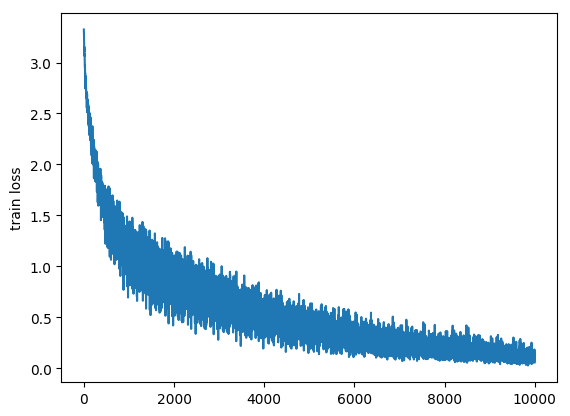

In [27]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

### 2.4 模型验证

In [28]:
model.eval()
translation_results = []

correct = 0
error = 0
# 因为batch_size是1，所以每次取出来的都是单个句子
for src_seq, tgt_seq in test_loader:
    encoder_inputs = src_seq
    hidden = model.encoder(encoder_inputs)
    pred_seq = [tgt_vocab['<bos>']]
    for _ in range(8):
        # 一步步输出，decoder的输入的形状为(batch_size, seq_len)=(1,1)
        decoder_inputs = torch.tensor(pred_seq[-1]).reshape(1, 1)
        # pred形状为 (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
        pred, hidden = model.decoder(decoder_inputs, hidden)
        next_token_index = pred.squeeze().argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)
    
    # 去掉开头的<bos>
    pred_seq = tgt_vocab[pred_seq[1:]]
    # 因为tgt_seq的形状为(1, seq_len)，我们需要将其转化成(seq_len, )的形状
    tgt_seq = tgt_seq.squeeze().tolist()
    
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
    translation_results.append((' '.join(tgt_seq), ' '.join(pred_seq)))
    
    for i in range(len(tgt_seq)):
        if i >= len(pred_seq) or pred_seq[i] != tgt_seq[i]:
            error += 1
        else:
            correct += 1

print(correct/(correct+error))

0.471


In [29]:
translation_results

[('u r f c p h', 'u r f c b u'),
 ('j z b d j h', 'q z p t d l'),
 ('e n s z i z', 'e n s j h e'),
 ('v r p i s j', 'v r y i j n'),
 ('g a v i p r', 'g a i v p n'),
 ('q v n f i k', 'v q n f k v'),
 ('f p o u l y', 'f p o u t w'),
 ('h f z d o a', 'h z f d o s'),
 ('x h i s z u', 'y h i s z v'),
 ('i t y x c h', 'i t n j h k'),
 ('d z a x s j', 'd a z x c h'),
 ('f q y a v i', 'f i a v i c'),
 ('t y k p m w', 't y k t g y'),
 ('b v b p x r', 'b v p t e n'),
 ('a y m r u g', 'a y m a r c'),
 ('p u x q u i', 'p u x m q h'),
 ('j h p k p f', 'j h z p o z'),
 ('t t f a d v', 't f a r i c'),
 ('z n k g s i', 'z n k v e'),
 ('k c j n m y', 'k c j n m p'),
 ('r y c o g v', 'r k i n o v'),
 ('y g f b a j', 'y g f v a p'),
 ('x x d g c a', 'x x d u g c'),
 ('r j a w n z', 'r j l m n z'),
 ('m d u u a m', 'm d u g c r'),
 ('x m w x g a', 'x w t x y b'),
 ('h q a d s q', 'h q a y t j'),
 ('n x q g e b', 'n x u e n b'),
 ('z o o u y r', 'z o y u o l'),
 ('a c m x f w', 'a z m g h c'),
 ('k c k y a

In [30]:
for src_seq, tgt_seq in test_loader:
    print(src_seq)

tensor([[ 6, 17, 26, 19, 13, 10,  1]])
tensor([[24, 14, 22,  7, 27, 10,  1]])
tensor([[ 8, 20,  4, 14, 21, 14,  1]])
tensor([[18, 17, 13, 21,  4, 27,  1]])
tensor([[11,  3, 18, 21, 13, 17,  1]])
tensor([[24, 18, 20, 26, 21,  9,  1]])
tensor([[26, 13, 23,  6, 12,  5,  1]])
tensor([[10, 26, 14,  7, 23,  3,  1]])
tensor([[ 2, 10, 21,  4, 14,  6,  1]])
tensor([[21, 16,  2, 25, 19, 10,  1]])
tensor([[ 7, 14,  3, 25,  4, 27,  1]])
tensor([[26, 21,  3,  3, 18, 21,  1]])
tensor([[16,  2,  9, 13, 15,  5,  1]])
tensor([[22, 18, 22, 13, 19, 17,  1]])
tensor([[ 3,  2, 15, 17,  6, 16,  1]])
tensor([[13,  6, 25, 24,  6, 21,  1]])
tensor([[27, 10, 13, 12, 13, 26,  1]])
tensor([[16, 16, 26,  3,  7, 21,  1]])
tensor([[14, 20,  9, 11,  4, 21,  1]])
tensor([[ 9, 19, 27, 20, 15,  2,  1]])
tensor([[17,  9, 19, 23, 11, 18,  1]])
tensor([[ 2, 11, 26, 22,  3, 27,  1]])
tensor([[25, 25,  7, 11,  6,  3,  1]])
tensor([[17, 27, 27,  5, 20, 14,  1]])
tensor([[15,  7,  6,  6,  3, 15,  1]])
tensor([[25, 15,  5, 25, 

In [ ]:
soundmark = ['ei',  'bi:',  'si:',  'di:',  'i:',  'ef',  'dʒi:',  'eit∫',  'ai', 'dʒei', 'kei', 'el', 'em', 'en', 'əu', 'pi:', 'kju:',
        'ɑ:', 'es', 'ti:', 'ju:', 'vi:', 'd∧blju:', 'eks', 'wai', 'zi:']

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
         'r','s','t','u','v','w','x','y','z']
# 从音标到字母到序列转换模型

In [48]:
for src_seq, tgt_seq in test_loader:
    src_seq = src_vocab[src_seq.squeeze().tolist()]
    print(' '.join(src_seq))

ju: ɑ: ef si: pi: eit∫ <eos>
kju: zi: bi: di: dʒei eit∫ <eos>
i: en es zi: ai zi: <eos>
vi: ɑ: pi: ai es dʒei <eos>
dʒi: ei vi: ai pi: ɑ: <eos>
kju: vi: en ef ai kei <eos>
ef pi: əu ju: el d∧blju: <eos>
eit∫ ef zi: di: əu ei <eos>
wai eit∫ ai es zi: ju: <eos>
ai ti: wai eks si: eit∫ <eos>
di: zi: ei eks es dʒei <eos>
ef ai ei ei vi: ai <eos>
ti: wai kei pi: em d∧blju: <eos>
bi: vi: bi: pi: si: ɑ: <eos>
ei wai em ɑ: ju: ti: <eos>
pi: ju: eks kju: ju: ai <eos>
dʒei eit∫ pi: el pi: ef <eos>
ti: ti: ef ei di: ai <eos>
zi: en kei dʒi: es ai <eos>
kei si: dʒei en em wai <eos>
ɑ: kei si: əu dʒi: vi: <eos>
wai dʒi: ef bi: ei dʒei <eos>
eks eks di: dʒi: ju: ei <eos>
ɑ: dʒei dʒei d∧blju: en zi: <eos>
em di: ju: ju: ei em <eos>
eks em d∧blju: eks es ei <eos>
eit∫ kju: ei di: es kju: <eos>
en eks kju: wai i: bi: <eos>
zi: əu əu ju: wai ɑ: <eos>
ei si: em eks ef d∧blju: <eos>
kei si: kei wai ei ɑ: <eos>
zi: si: kju: dʒei eit∫ ei <eos>
ei kju: zi: vi: eks ai <eos>
ei ti: ɑ: dʒei i: zi: <eos>
en el e

In [49]:
translation_results

[('u r f c p h', 'u r f c b u'),
 ('j z b d j h', 'q z p t d l'),
 ('e n s z i z', 'e n s j h e'),
 ('v r p i s j', 'v r y i j n'),
 ('g a v i p r', 'g a i v p n'),
 ('q v n f i k', 'v q n f k v'),
 ('f p o u l y', 'f p o u t w'),
 ('h f z d o a', 'h z f d o s'),
 ('x h i s z u', 'y h i s z v'),
 ('i t y x c h', 'i t n j h k'),
 ('d z a x s j', 'd a z x c h'),
 ('f q y a v i', 'f i a v i c'),
 ('t y k p m w', 't y k t g y'),
 ('b v b p x r', 'b v p t e n'),
 ('a y m r u g', 'a y m a r c'),
 ('p u x q u i', 'p u x m q h'),
 ('j h p k p f', 'j h z p o z'),
 ('t t f a d v', 't f a r i c'),
 ('z n k g s i', 'z n k v e'),
 ('k c j n m y', 'k c j n m p'),
 ('r y c o g v', 'r k i n o v'),
 ('y g f b a j', 'y g f v a p'),
 ('x x d g c a', 'x x d u g c'),
 ('r j a w n z', 'r j l m n z'),
 ('m d u u a m', 'm d u g c r'),
 ('x m w x g a', 'x w t x y b'),
 ('h q a d s q', 'h q a y t j'),
 ('n x q g e b', 'n x u e n b'),
 ('z o o u y r', 'z o y u o l'),
 ('a c m x f w', 'a z m g h c'),
 ('k c k y a